# Build a linear regression model on whoop data to predict next day's recovery based on previous day metrics

### target performance / metric: make recovery score predictions within 10% (lower or higher) than ground truth recovery score

165 days of data  
8 features  
1 target variable: recovery score  


In [147]:
#import statements
import pandas as pd
import numpy as np

## load dataset

In [170]:
#load data
df = pd.read_csv("../data/pre_scaled_feature_table.csv")
#remove date for training purposes, useful to investigate later when doing error analysis
del df['Unnamed: 0.1']
del df['Unnamed: 0']
del df['Date']
df.describe()

,Recovery score %,Resting heart rate (bpm),Heart rate variability (ms),Day Strain,Average HR (bpm),Respiratory rate (rpm),Asleep duration (min),Deep (SWS) duration (min),REM duration (min)
count,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000
mean,61.018182,59.436364,60.321212,10.326061,72.472727,18.843636,439.321212,109.503030,102.466667
std,19.393069,2.926521,14.868114,3.520981,3.954873,0.381475,54.481927,20.939409,40.910153
min,16.000000,54.000000,30.000000,4.000000,64.000000,17.900000,274.000000,50.000000,6.000000
25%,46.000000,57.000000,51.000000,7.400000,70.000000,18.600000,405.000000,95.000000,76.000000
50%,61.000000,59.000000,56.000000,10.300000,72.000000,18.800000,448.000000,112.000000,105.000000
75%,74.000000,61.000000,66.000000,13.200000,74.000000,19.100000,479.000000,124.000000,135.000000
max,98.000000,68.000000,111.000000,18.600000,89.000000,19.900000,563.000000,159.000000,213.000000


In [171]:
#have to do this in model notebook not data prep notebook to make predictions
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#x, y definition (recovery score is target variable y)
#scale features
features = [f for f in df.columns.to_list() if f != "Recovery score %"]
x, y = df[features], df["Recovery score %"]
x_scaled = scaler.fit_transform(x)

scaled_df = pd.DataFrame(x_scaled, columns=features)
#add target y back
scaled_df = pd.concat([scaled_df, y], axis=1)
scaled_df.to_csv("../data/feature_table.csv")
scaled_df.describe() #look for mean of 0 and std of 1

,Resting heart rate (bpm),Heart rate variability (ms),Day Strain,Average HR (bpm),Respiratory rate (rpm),Asleep duration (min),Deep (SWS) duration (min),REM duration (min),Recovery score %
count,1.650000e+02,1.650000e+02,1.650000e+02,1.650000e+02,1.650000e+02,1.650000e+02,1.650000e+02,1.650000e+02,165.000000
mean,-3.983346e-16,4.575465e-17,-5.167584e-16,9.124015e-16,-1.507212e-16,1.291896e-16,1.722528e-16,-4.306320e-17,61.018182
std,1.003044e+00,1.003044e+00,1.003044e+00,1.003044e+00,1.003044e+00,1.003044e+00,1.003044e+00,1.003044e+00,19.393069
min,-1.863275e+00,-2.045553e+00,-1.802145e+00,-2.148873e+00,-2.481181e+00,-3.043660e+00,-2.850327e+00,-2.365191e+00,16.000000
25%,-8.350463e-01,-6.288348e-01,-8.335655e-01,-6.271389e-01,-6.406133e-01,-6.318736e-01,-6.947273e-01,-6.489156e-01,46.000000
50%,-1.495605e-01,-2.915209e-01,-7.424051e-03,-1.198942e-01,-1.147367e-01,1.597816e-01,1.196104e-01,6.211282e-02,61.000000
75%,5.359252e-01,3.831067e-01,8.187174e-01,3.873505e-01,6.740781e-01,7.305097e-01,6.944370e-01,7.976594e-01,74.000000
max,2.935125e+00,3.418931e+00,2.357050e+00,4.191686e+00,2.777584e+00,2.276999e+00,2.371015e+00,2.710081e+00,98.000000


## create train/test set

opting for only 0.2 test size due to low number of training examples (165)

In [172]:
#define input features X and target variable y
features = [f for f in df.columns.to_list() if f != "Recovery score %"] #create list of feature names
X, y = scaled_df[features], scaled_df["Recovery score %"] #define features X and target variable y
print(X.shape, y.shape)

(165, 8) (165,)


In [173]:
#create train/test sets
from sklearn.model_selection import train_test_split

#X_train are the features of the training set, y_train are the target variables/outcomes for those features, same thing for test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(132, 8) (33, 8) (132,) (33,)


## train linear regression model

In [174]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression() #create linear regression model instance
lin_reg.fit(X_train, y_train)

LinearRegression()

### What Happens Inside `lin_reg.fit(X_train, y_train)`

When you call `lin_reg.fit(X_train, y_train)`, scikit-learn’s `LinearRegression` does the following:

---

#### 1. Understands Your Data
- It checks that `X_train` (your features) is a table with rows and columns.
- It checks that `y_train` (your target) is a single column of values.
- It prepares the data so that it can find the best line (or plane) to fit.

---

#### 2. Defines the Goal (Cost Function)
- The goal is to find coefficients (weights) that minimize prediction errors.
- The error is measured using **Mean Squared Error (MSE)**:
  \[
  MSE = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2
  \]
  where \(\hat{y}_i\) is the prediction for row \(i\).

---

#### 3. Finds the Best Coefficients
- Instead of guessing coefficients and adjusting them (like gradient descent), it uses a **mathematical shortcut (least squares)** to directly calculate the best values.
- Under the hood, it uses a method called **SVD (Singular Value Decomposition)** — a stable way to find the exact solution.

---

#### 4. Saves the Model Parameters
- The numbers it finds (coefficients and intercept) are saved in:
  ```python
  lin_reg.coef_      # effect of each feature
  lin_reg.intercept_ # baseline prediction


## Investigate linear regression model

In [175]:
#a linear regression model estimates weights and y intercept w, b
print(lin_reg.intercept_) #scalar value
print(lin_reg.coef_) #weight for each feature, so (8,) 1D array because I have 8 featuress

61.360437113338435
[-5.03812053 14.43515425  1.32598386  0.4297943   2.55894976  1.71592431
  0.32791825  4.05687489]


In [176]:
#the magnitude of the features indicates how significantly they affect the target variable y
coeffs = {}
for feature, coef in zip(X_train.columns, lin_reg.coef_):
    coeffs[feature] = coef
sorted_coeffs = dict(sorted(coeffs.items(), key=lambda item: item[1], reverse=True)) # sort dict by descending values
sorted_coeffs

{'Heart rate variability (ms)': np.float64(14.435154247303394),
 'REM duration (min)': np.float64(4.056874893123921),
 'Respiratory rate (rpm)': np.float64(2.558949760543545),
 'Asleep duration (min)': np.float64(1.7159243129340414),
 'Day Strain': np.float64(1.3259838559710135),
 'Average HR (bpm)': np.float64(0.42979429508267264),
 'Deep (SWS) duration (min)': np.float64(0.3279182477276484),
 'Resting heart rate (bpm)': np.float64(-5.038120529961978)}

## Evaluate coefficients

<BarContainer object of 8 artists>

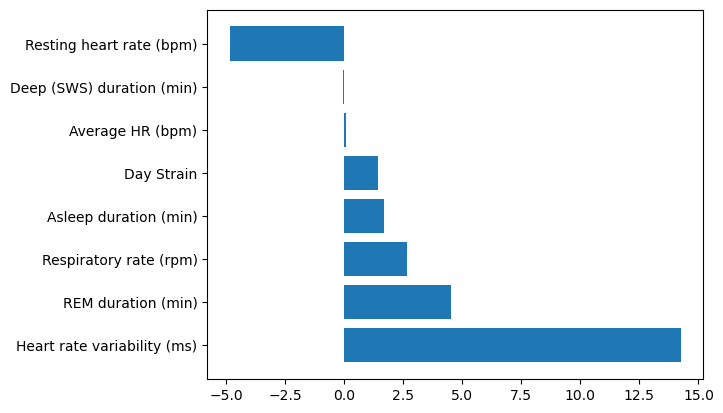

In [155]:
import matplotlib.pyplot as plt
#bar plot of coefficients
features = [item[0] for item in sorted_coeffs.items()]
values = [item[1] for item in sorted_coeffs.items()]

plt.barh(features, values)


## Heart rate variability is the most impactful feature on recovery score (14.4)

## Make predictions on test set and compute MSE mean squared error

In [156]:
from sklearn.metrics import mean_squared_error

y_pred = lin_reg.predict(X_test) # make preidcition on test set inputs
mse = mean_squared_error(y_test, y_pred) #calculate mean squared error on test set predicitons -> how far were predictions from ground truth number
rmse = mse ** 0.5  # Square root of MSE

print("mse: " + str(mse))
print("rmse: " + str(rmse))

mse: 74.00805387841146
rmse: 8.602793376480191


## Plot predictions vs actual values

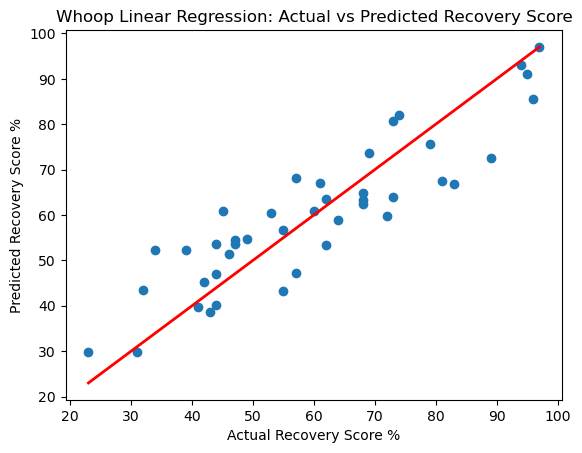

In [157]:
#create scatter plot
plt.scatter(y_test, y_pred)

plt.xlabel("Actual Recovery Score %")
plt.ylabel("Predicted Recovery Score %")

plt.title("Whoop Linear Regression: Actual vs Predicted Recovery Score")

#add perfect prediction line
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color="red", linewidth=2)  # Perfect prediction line
plt.show()

## plot model accuracy via one selected feature just to visualize: (can't do all 8 at once and visualize)
so opting for HR variability due to strongest correlation



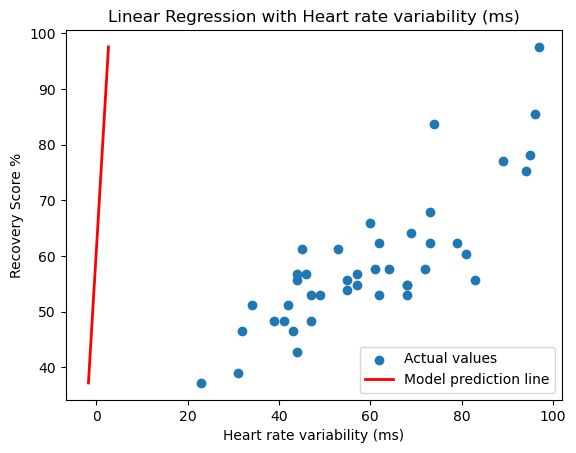

In [158]:
# 1. Select just one feature
feature = "Heart rate variability (ms)"
X_train_hrv = X_train[[feature]]
X_test_hrv = X_test[[feature]]

# 2. Create and fit a new linear regression model with only this feature
lin_reg_hrv = LinearRegression()
lin_reg_hrv.fit(X_train_hrv, y_train)

#3. Predict values using this 1-feature model
y_pred_hrv = lin_reg_hrv.predict(X_test_hrv)

#4. plot data points
plt.scatter(y_test, y_pred_hrv, label="Actual values")

#5. Plot regression line
sorted_idx = np.argsort(X_test_hrv.values.ravel())
"""arr = [50, 10, 30] #indices to sort array
np.argsort(arr)
# Output: [1, 2, 0]"""
plt.plot(
    X_test_hrv.values[sorted_idx],
    y_pred_hrv[sorted_idx],
    color="red",
    linewidth=2,
    label="Model prediction line"
)

plt.xlabel(feature)
plt.ylabel("Recovery Score %")
plt.title(f"Linear Regression with {feature}")
plt.legend()
plt.show()

## HRV alone doesn't capture recovery score well...even though it had the largest coeeficcient: 1. Coefficients Depend on Feature Scale
Myfeatures were standardized (mean = 0, std = 1), so the magnitude of a coefficient does represent importance in the context of the model, but only when combined with other features.
A large positive coefficient means that when all other features are fixed, increasing HRV (by 1 standard deviation) increases recovery score by ~14.4 points.

## Evaluate how good initial linear regression model (all features) was with R^2 correlation test

R² = 1: Perfect prediction.  
R² = 0: Model is no better than predicting the mean.  
R² < 0: Model performs worse than just guessing the mean.


In [159]:
from sklearn.metrics import r2_score

#r2 for full model
r2 = r2_score(y_test, y_pred)

#r2 for hrv only model
r2_hrv = r2_score(y_test, y_pred_hrv)

#r2 for predicting avg recovery score
r2_avg = r2_score(y_test, np.full(len(y_test), y_train.mean()))#create vector containing mean for each prediction example

print("model r2: " + str(r2) + "\n",
      "hrv only r2: " + str(r2_hrv) + "\n",
      "avg r2: " + str(r2_avg))

model r2: 0.7933782919486227
 hrv only r2: 0.6437161811829746
 avg r2: -0.0062283440897499265


An R² score of 0.79 means the model explains about 79% of the variance in the Recovery Score % on the test set.

model outperforms single feature hrv only mean guessing models

## evaluation metric testing: 17 points away from true score:
out of all predictions, how many times was the model within 17 points on either side (higher or lower prediction) than the true recovery score for that day?  
because Whoop recovery has 3 tiers/bands (poor,good,excellent) recoveries, (17 points allows a high or low prediction within the same recovery third)

example: recovery score is 75 %

17 points error allowance means a prediction between  
58 to 92

In [160]:
#store percent error between truth and predicted value in array
points_error = np.abs(y_test - y_pred)

#count number of safe predictions (<= 17 %)
safe_predictions = points_error <=17 #True = 1, False = 0
safe_percent = (np.sum(safe_predictions) / len(safe_predictions)) * 100
safe_percent

np.float64(97.61904761904762)

## ~96% of the time, the model predicted a recovery score within 17 points of the ground truth recovery score
not bad for multivariate model with only 164 days of data!

## sumarrize models (full, hrv, avg)

MSE, r, r2, target metric (17% error)

In [161]:
y_pred_avg = np.full(len(y_test), y_train.mean())

#mean squared error
mse = mean_squared_error(y_test, y_pred)
mse_hrv = mean_squared_error(y_test, y_pred_hrv)
mse_avg = mean_squared_error(y_test, y_pred_avg)

#r linear correlation : > 0.75 strong linear correlation
r = np.sqrt(r2)
r_hrv = np.sqrt(r2_hrv)
r_avg = np.sqrt(r2_avg)

#within 17%
points_error_hrv = np.abs(y_test - y_pred_hrv)
safe_predictions_hrv = points_error_hrv <= 17
safe_percent_hrv = (np.sum(safe_predictions_hrv) / len(safe_predictions_hrv)) * 100

points_error_avg = np.abs(y_test - y_pred_avg)
safe_predictions_avg = points_error_avg <= 17
safe_percent_avg = (np.sum(safe_predictions_avg) / len(safe_predictions_avg)) * 100

#print model summaries:
print("Linear Regression Model (8 features):")
print(f"mse: {mse}")
print(f"r: {r}")
print(f"safe predictions %: {safe_percent}")

print("Linear Regression Model (HRV):")
print(f"mse: {mse_hrv}")
print(f"r: {r_hrv}")
print(f"safe predictions %: {safe_percent_hrv}")

print("Average guess model:")
print(f"mse: {mse_avg}")
print(f"r: {r_avg}")
print(f"safe predictions %: {safe_percent_avg}")



Linear Regression Model (8 features):
mse: 74.00805387841146
r: 0.8907178520432959
safe predictions %: 97.61904761904762
Linear Regression Model (HRV):
mse: 127.61423912176804
r: 0.8023192514099201
safe predictions %: 90.47619047619048
Average guess model:
mse: 360.4122829381604
r: nan
safe predictions %: 54.761904761904766


/var/folders/bz/t2rlkxxj1p791fxqscm96q_40000gn/T/ipykernel_65434/357732289.py:11: RuntimeWarning: invalid value encountered in sqrt
  r_avg = np.sqrt(r2_avg)


# ITERATE  

bump up test size to 0.15 and 0.25 (0.05 changes)  

# test size = 0.2  
Linear Regression Model (8 features):  
mse: 70.57840594177391  
r: 0.8899720609568009  
safe predictions %: 96.96969696969697  
Linear Regression Model (HRV):  
mse: 137.79025058576894  
r: 0.7707267065978157  
safe predictions %: 90.9090909090909  
Average guess model:  
mse: 346.75688705234165  
r: nan  
safe predictions %: 57.57575757575758  
  
# test size = 0.15  
Linear Regression Model (8 features):  
mse: 77.67923855945368  
r: 0.8793244493080461  
safe predictions %: 96.0  
Linear Regression Model (HRV):  
mse: 150.8133546336653  
r: 0.7481261204045322  
safe predictions %: 92.0  
Average guess model:  
mse: 344.0737653061224  
r: nan  
safe predictions %: 56.00000000000001  
  
# test size = 0.25  
Linear Regression Model (8 features):  
mse: 74.00805387841146  
r: 0.8907178520432959  
safe predictions %: 97.61904761904762  
Linear Regression Model (HRV):  
mse: 127.61423912176804  
r: 0.8023192514099201  
safe predictions %: 90.47619047619048  
Average guess model:  
mse: 360.4122829381604  
r: nan  
safe predictions %: 54.761904761904766  

# test size = 0.2 is best overall: highest r linear correlation) and safe prediction percentage

## predictor: upload new features and predict next morning's recovery score

In [188]:
def predict_score(X):
    """
    Predict the next day recovery score based on input features X.
    Applies the same StandardScaler as used during training.
    """
    # Ensure input is a 2D array
    X = np.array(X).reshape(1, -1)

    # Scale input features using the same scaler used for training
    X_scaled = scaler.transform(X)

    # Predict using trained model
    return lin_reg.predict(X_scaled)[0]


In [192]:
# Example input for one day (must follow the same order of features as training) #need to scale back feattures
#sample data for july 23, 2025
example_features = [
    6.5,    # Day Strain
    68,     # Resting heart rate (bpm)
    43,     # Heart rate variability (ms)
    73,     # Average HR (bpm)
    18.5,     # Respiratory rate (rpm)
    377,    # Asleep duration (min)
    85,     # Deep (SWS) duration (min)
    92     # REM duration (min)
]

predicted_score = predict_score(example_features)
print(f"Predicted Recovery Score: {predicted_score:.2f}") #prediction over 100?

Predicted Recovery Score: 166.94


/opt/anaconda3/envs/jupyter-env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/jupyter-env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


## need to cap at 100